<a href="https://colab.research.google.com/github/northpr/tensorflow-resources/blob/main/udemy_tensorflow_course/09_skimlit_nlp_w_detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using https://arxiv.org/abs/1710.06071)

In [ ]:
!nvidia-smi

Tue Jul 19 23:11:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparing the Data

## Getting the Data
The data (PubMed 200k RCT) is on the [Github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Check what files are in the PubMed dataset

In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments uding the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data
Understanding the data and one of the best option is visualize the data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Read filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

### Planning how should our data look

```
[{
  'line_number':0,
  'target':'BACKGROUND',
  'text':'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'',
  'total_lines': 11}],
  .........
```

### Create preprocess text function

Write a function which turns each of our datasets into the above format.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = []

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line # getting the line number
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # checking to see if line is a new line (it could be \n)
      abstract_line_split = abstract_lines.splitlines() # sentece that split into a list

      # Iterate through each line in a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the target abstract
        abstract_samples.append(line_data) # add line data to abstract samples list      


    else: # if the above conditions aren't fullfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples
    

Get data from file and preprocess it

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 709 ms, sys: 124 ms, total: 833 ms
Wall time: 2.07 s


In [ ]:
# Check the first abstract of our time data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

## Create dataframe from preprocessed data
Now that our data is the format of a list of dictionaries, now turn into a DataFrame

In [ ]:
import pandas as pd
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples)

df_train.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Checking the distribution of labels in the training data

In [ ]:
df_train["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

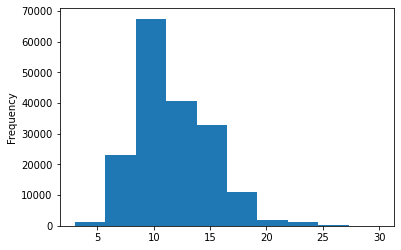

In [ ]:
# check the length of different lines
df_train["total_lines"].plot.hist()

Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = df_train["text"].tolist()
val_sentences = df_val["text"].tolist()
test_sentences = df_test["text"].tolist()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels and encode
Because Machine Learning models require numeric labels

In [ ]:
# to clarify the Numpy reshape(-1,1) https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(df_train["target"].to_numpy().reshape(-1,1))

 # don't need to fit anymore because we already fit_transform on train df
val_labels_one_hot = one_hot_encoder.transform(df_val["target"].to_numpy().reshape(-1,1)) 
test_labels_one_hot = one_hot_encoder.transform(df_test["target"].to_numpy().reshape(-1,1)) 

# Check what one hot encoded labels look like
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

Extract labels ("target" columns) and encode them into integers

In [ ]:
# Using label encoder to use in `Naive Bayes` model
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(df_train["target"].to_numpy())
val_labels_encoded = label_encoder.transform(df_val["target"].to_numpy())
test_labels_encoded = label_encoder.transform(df_test["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

Get class names and number of classes from LabelEncoded instance

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Create a machine learning model experiments
* Model 0: Naive Bayes with TF-IDF
* Model 1: Cov1D with token embeddings
* Model 2: TensorFlow Hub Pretrained Feature Extractor Mode
* Model 4: Pretrained token embedding (same as 2) + chracter embeddings (same as 3)
* Model 5: Pretrained token embeddings + character embeddings + positional embeddings


## Model 0: Naive Bayes with TF-IDF

### Create a pipeline for the model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Evaluate baseline model on validation dataset

In [ ]:
model_0.score(val_sentences,
              val_labels_encoded)

0.7218323844829869

Make predictions using our baseline model

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
val_labels_encoded[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

# Tokenization and Embedding

## Analyze and visualize the data

In [ ]:
# Download helper function script to evaluate the model easier

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-07-19 23:12:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-19 23:12:22 (48.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

# Calculate baseline results
model_0_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
# How long is each sentence on average?
import numpy as np

sent_lens = [len(sentence.split()) for sentence in train_sentences] # Split to the single word or special letter, find the length of it and put it in the list.
avg_sent_len = np.mean(sent_lens)
print(f"Average sentence range: {avg_sent_len}")

Average sentence range: 26.338269273494777


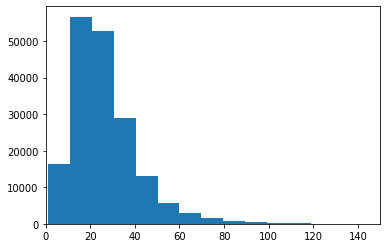

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30)
plt.xlim(0,150);

How long gof a sentence length covers 95% of examples

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
print(f"Calculate 95% of the sentence length by using percentile at 95 is: {output_seq_len}")

Calculate 95% of the sentence length by using percentile at 95 is: 55


Maximum sequence length in the training set

In [ ]:
max(sent_lens)

296

## Text Vectorization

### Create text vectorizer

In [ ]:
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization variables
max_vocab_length = 68000 # max number of words, check in https://arxiv.org/pdf/1710.06071.pdf at 3.2

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   output_mode='int',
                                   output_sequence_length=output_seq_len) # max length our sequence will be

Adapt text vectorizer to training sentences.

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test our text vectorizer on random train sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer(target_sentence)}")

Text: 
despite their low cost , printed educational messages should not be routinely used in attempting to close evidence-practice gaps relating to diabetic retinopathy screening .

Length of text: 25

Vectorized text: [  643   120   220   608  7030   904  1958   406    31    36  3839    98
     5  9232     6  3607 58290  6526  5408     6  1062  3007   387     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [ ]:
# Test our text vectorizer on random val sentences
random_val_sentence = random.choice(val_sentences)
print(f"Text: \n{random_val_sentence}")
print(f"\nLength of text: {len(random_val_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer(random_val_sentence)}")

Text: 
despite the brief duration of treatment , aleglitazar induced favorable changes in glycosylated hemoglobin and blood lipids , similar for participants with t@d or prediabetes .

Length of text: 26

Vectorized text: [  643     2   960   282     4    19 11305   858  1599   146     5  5661
  1088     3   107  2120   150    11    60     7  1990    16  5632     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


Finding how many words in our training vocabulary

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:10]}")
print(f"Most least words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Most least words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Text Embedding

In [ ]:
### Create custom text embedding
from tensorflow.keras.layers import Embedding
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                     output_dim=128, # Note: different embedding size result in drastivcally different number of parameters
                                     mask_zero=True, # use masking to help Tensorflow run faster when have a lot of zero
                                     input_length=output_seq_len) # how long is each input

In [ ]:
print(f"Sentence before vectorization: \n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before emvedding:\n{vectorized_sentence}")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
despite their low cost , printed educational messages should not be routinely used in attempting to close evidence-practice gaps relating to diabetic retinopathy screening .

Sentence after vectorization (before emvedding:
[[  643   120   220   608  7030   904  1958   406    31    36  3839    98
      5  9232     6  3607 58290  6526  5408     6  1062  3007   387     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
[[[-0.0003777   0.01603795  0.00986506 ... -0.04770368 -0.00121937
   -0.02874452]
  [ 0.0146139   0.00742967 -0.02558907 ...  0.0364063   0.0395853
   -0.04071699]
  [-0.02988691  0.00675461 -0.0388642  ...  0.001798    0.02873722
   -0.03681352]
  ...
  [-0.03857499 -0.01549007  0.04650683 ... -0.04599699 -0.01453016
    0.01689306]
  [-0.03857499 -0.01549007  0.04650683 .

## Creating datasets (making sure our data loads as fast as possible)

We're going to set up our data to run as fast as possible with tf.data API, many of the steps here are discuss in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
len(train_sentences), train_labels_one_hot.shape, train_labels_one_hot[0]

(180040, (180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Now data is set into Prefetch dataset so we could do further with faster performance.

# Continue create machine learning model with Neural Network

## Model 1: Conv1D with token embeddings

### Building a Model

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # Create Embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings) # kernel_size=5 is looking for 5 words as group
x = layers.GlobalMaxPooling1D()(x) 
outputs = layers.Dense(num_classes, activation="softmax")(x) # unit = length of the array of the traget

model_1 =tf.keras.Model(inputs,outputs)


In [ ]:
# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=5,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 15s 6ms/step - loss: 0.8420 - accuracy: 0.6814 - val_loss: 0.5912 - val_accuracy: 0.7822
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.5806 - accuracy: 0.7884 - val_loss: 0.5374 - val_accuracy: 0.8039
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.5459 - accuracy: 0.7995 - val_loss: 0.5188 - val_accuracy: 0.8165
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.5274 - accuracy: 0.8079 - val_loss: 0.5165 - val_accuracy: 0.8055
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.5318 - accuracy: 0.8055 - val_loss: 0.4934 - val_accuracy: 0.8195


### Evaluate the model

In [ ]:
# Evaluate on the validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4976 - accuracy: 0.8185


[0.4976295232772827, 0.8185489177703857]

### Probability as softmax version

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[3.5267785e-01, 4.9055499e-01, 5.0345794e-03, 1.0297673e-01,
        4.8755858e-02],
       [3.6225748e-01, 5.4615885e-01, 1.9093190e-03, 6.7742936e-02,
        2.1931427e-02],
       [2.4575555e-01, 8.6817309e-02, 5.1099040e-02, 6.1292511e-01,
        3.4030273e-03],
       ...,
       [4.1000548e-04, 1.2985363e-03, 2.5706276e-02, 2.3456308e-04,
        9.7235066e-01],
       [2.0266004e-02, 6.0758239e-01, 2.9012254e-02, 1.1861283e-02,
        3.3127809e-01],
       [6.5174028e-02, 9.2463607e-01, 5.6829951e-03, 2.3879036e-03,
        2.1190029e-03]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 81.85489209585594,
 'f1': 0.8157046887038292,
 'precision': 0.8202281931684678,
 'recall': 0.8185489209585595}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pre-trained word embeddings
Use pretrained word embedding from Tensorflow Hub, more specifically the universal sentence encoder.

Now lets use pretrained word embeddings from TensorFlow Hub: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        name="universal_sentence_encoder")

In [ ]:
# Test our pretrained model
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 all clinical event rates were markedly lower in russia/georgia , and there was no detectable impact of spironolactone on any outcomes .
Sentence after embedding:
 [[-3.55132595e-02 -7.44889909e-03 -2.13611475e-03 -5.12686074e-02
   3.91081534e-02  2.52534728e-02  7.41506070e-02 -3.19857374e-02
   2.04309542e-02  7.74944499e-02  8.88233855e-02 -7.89862312e-03
   5.54991551e-02  4.02069986e-02  4.49381359e-02  2.04728581e-02
  -8.96262154e-02  1.93761960e-02  4.74778488e-02 -2.65257750e-02
   3.04916501e-02  7.61814415e-02 -5.27542233e-02  5.20701222e-02
  -6.57896847e-02 -3.22540924e-02  3.34457867e-02  2.01899335e-02
  -3.07721440e-02  6.67269006e-02 -8.04884546e-03  9.33497995e-02
   7.35818967e-02  5.07948399e-02 -3.45608182e-02 -3.57077941e-02
  -6.92559928e-02 -1.30655700e-02  3.95556949e-02  2.62660198e-02
  -6.18859082e-02  7.42152780e-02  3.04501341e-03 -2.04851385e-02
   7.41237625e-02 -5.76350605e-04  3.44627723e-02  5.06222956e-02
   2.07416601e-02  3.188448

### Building a model.

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string) # need to use empty list for shape due to the tensorflow hub
embedded_layer = tf_hub_embedding_layer(inputs)
x = layers.Dense(64, activation="relu")(embedded_layer)

# Note: you could add more layers if you wanated
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
history_2 = model_2.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9582 - accuracy: 0.6378 - val_loss: 0.8077 - val_accuracy: 0.6822
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7803 - accuracy: 0.6962 - val_loss: 0.7666 - val_accuracy: 0.7001
Epoch 3/5
562/562 [==============================] - 6s 12ms/step - loss: 0.7666 - accuracy: 0.7065 - val_loss: 0.7550 - val_accuracy: 0.7094
Epoch 4/5
562/562 [==============================] - 12s 21ms/step - loss: 0.7349 - accuracy: 0.7170 - val_loss: 0.7328 - val_accuracy: 0.7181
Epoch 5/5
562/562 [==============================] - 9s 17ms/step - loss: 0.7467 - accuracy: 0.7128 - val_loss: 0.7123 - val_accuracy: 0.7214


### Evaluate Model

In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7180 - accuracy: 0.7258


[0.7179844975471497, 0.7258374094963074]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.59871614, 0.26850334, 0.00407729, 0.11784363, 0.01085964],
       [0.4106371 , 0.49285945, 0.00512897, 0.0883146 , 0.00305993],
       [0.3474609 , 0.0865142 , 0.03373582, 0.48109493, 0.05119417],
       ...,
       [0.00259736, 0.0027661 , 0.12039094, 0.00102926, 0.8732164 ],
       [0.00254128, 0.01993473, 0.50311595, 0.00096104, 0.473447  ],
       [0.15550403, 0.22749655, 0.57578564, 0.00280938, 0.0384044 ]],
      dtype=float32)

In [ ]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 2])>

In [ ]:
# Calculate the results from TF Hub pretrained embeddings results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 72.58374155964518,
 'f1': 0.7202778594041731,
 'precision': 0.721693871736448,
 'recall': 0.7258374155964518}

## Model 3:Conv1D with character embeddings

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Create a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Text spliting non-character-level sequence into characters
split_chars(random_train_sentence)

'a l l   c l i n i c a l   e v e n t   r a t e s   w e r e   m a r k e d l y   l o w e r   i n   r u s s i a / g e o r g i a   ,   a n d   t h e r e   w a s   n o   d e t e c t a b l e   i m p a c t   o f   s p i r o n o l a c t o n e   o n   a n y   o u t c o m e s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

149.3662574983337

(0.0, 800.0)

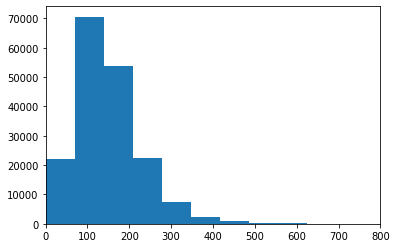

In [ ]:
# Check the distribution of our sequences at a character-levle
plt.hist(chars_len,bins=20)
plt.xlim(0,800)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 spacee and OOV (Out of vocab token)
NUM_CHAR_TOKENS

70

In [ ]:
# Create char-level token vectorizer instance
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, #70
                                    output_sequence_length=output_seq_char_len, #290
                                    standardize=None,
                                    name='char_vectorizer') 
                                    

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"10 most common characters: {char_vocab[:10]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 57
10 most common characters: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
5 least common characters: ['|', '"', ']', '\\', '[']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\n Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars:\n {vectorized_chars}")
print(f"\n Length of vectorzied chars: {len(vectorized_chars[0])}")

Charified text:
 f u r t h e r   s t u d i e s   u s i n g   v o i d i n g   d i a r i e s   a n d   e x c l u d i n g   p a t i e n t s   w i t h   n o c t u r n a l   p o l y u r i a   w o u l d   b e   n e e d e d   t o   m o r e   p r e c i s e l y   e s t i m a t e   t h e   i m p a c t   o f   t a d a l a f i l   o n   n o c t u r i a   a s s o c i a t e d   w i t h   l u t s / b p h   .

 Length of random_train_chars: 379

 Vectorized chars:
 [[17 16  8  3 13  2  8  9  3 16 10  4  2  9 16  9  4  6 18 22  7  4 10  4
   6 18 10  4  5  8  4  2  9  5  6 10  2 30 11 12 16 10  4  6 18 14  5  3
   4  2  6  3  9 21  4  3 13  6  7 11  3 16  8  6  5 12 14  7 12 20 16  8
   4  5 21  7 16 12 10 23  2  6  2  2 10  2 10  3  7 15  7  8  2 14  8  2
  11  4  9  2 12 20  2  9  3  4 15  5  3  2  3 13  2  4 15 14  5 11  3  7
  17  3  5 10  5 12  5 17  4 12  7  6  6  7 11  3 16  8  4  5  5  9  9  7
  11  4  5  3  2 10 21  4  3 13 12 16  3  9 35 23 14 13 25  0  0  0  0  0
   0  0  0  0  0  0  0  0  0

### Creating a character-level embedding

In [ ]:
# Creating a character-level embedding
# https://arxiv.org/pdf/1612.05251.pdf
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters.
                              output_dim=25, # size of the char embedding in the paper.
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
print(f"Leghth of random train chars: {len(random_train_chars)}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"\nEmbedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Cjaracted embedding shape: {char_embed_example.shape}")

Charified text:
 f u r t h e r   s t u d i e s   u s i n g   v o i d i n g   d i a r i e s   a n d   e x c l u d i n g   p a t i e n t s   w i t h   n o c t u r n a l   p o l y u r i a   w o u l d   b e   n e e d e d   t o   m o r e   p r e c i s e l y   e s t i m a t e   t h e   i m p a c t   o f   t a d a l a f i l   o n   n o c t u r i a   a s s o c i a t e d   w i t h   l u t s / b p h   .

Leghth of random train chars: 379

Embedded chars (after vectorization and embedding):
 [[[-0.0066114   0.01414538 -0.02013879 ...  0.02699535  0.03430355
    0.00240944]
  [-0.04470313 -0.00572906 -0.02991126 ...  0.01512322  0.02405175
    0.03703859]
  [-0.02820447  0.04575152  0.04024763 ...  0.04695096  0.04995391
    0.04563396]
  ...
  [ 0.03578981 -0.01478906  0.0484083  ... -0.04249112  0.01320999
   -0.0379091 ]
  [ 0.03578981 -0.01478906  0.0484083  ... -0.04249112  0.01320999
   -0.0379091 ]
  [ 0.03578981 -0.01478906  0.0484083  ... -0.04249112  0.01320999
   -0.0379091 ]]]
Cjaracte

### Build a model

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embedded = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embedded)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs ,name="model_3_Conv1D_char_embeddings")

model_3.summary()

Model: "model_3_Conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Code below will run with less accuracy because we have create datasets for words only not character for this model.


In [ ]:
# history_3 = model_3.fit(train_dataset,
#                         epochs=5,
#                         steps_per_epoch=int(0.1*len(train_dataset)),
#                         validation_data=valid_dataset,
#                         validation_steps=int(0.1*len(valid_dataset)))

## Create char level datasets


In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

# Checking dataset
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Build a model with char datasets

In [ ]:
history_3 = model_3.fit(train_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 5ms/step - loss: 1.1667 - accuracy: 0.5323 - val_loss: 0.9323 - val_accuracy: 0.6313
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8888 - accuracy: 0.6472 - val_loss: 0.8401 - val_accuracy: 0.6695
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8199 - accuracy: 0.6810 - val_loss: 0.7774 - val_accuracy: 0.6985
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.7748 - accuracy: 0.7045 - val_loss: 0.7567 - val_accuracy: 0.7035
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.7648 - accuracy: 0.7067 - val_loss: 0.7233 - val_accuracy: 0.7207


### Evaluate the model

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7323 - accuracy: 0.7168


[0.732313334941864, 0.7167681455612183]

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.22613712, 0.61782944, 0.01970198, 0.12933749, 0.00699398],
       [0.26806894, 0.62367463, 0.0057991 , 0.0700276 , 0.03242974],
       [0.06640345, 0.5097481 , 0.13994001, 0.23451184, 0.04939665],
       ...,
       [0.00225137, 0.0024503 , 0.04246683, 0.00282702, 0.95000446],
       [0.01825335, 0.37082934, 0.2207045 , 0.01492592, 0.3752869 ],
       [0.43635848, 0.4000927 , 0.09503103, 0.052873  , 0.01564484]],
      dtype=float32)

In [ ]:
# Convert pred probs to class
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
# Calculate the results for Conv1D model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 71.67681715874487,
 'f1': 0.7109595235086337,
 'precision': 0.7187454543215217,
 'recall': 0.7167681715874487}

## Model 4: Combining pretrained token embeddings + characters embedding

Combining Model 2 and Model 3 together

### Build a model
1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with slight modification)
3. Combine 1&2 with concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_bybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2: https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

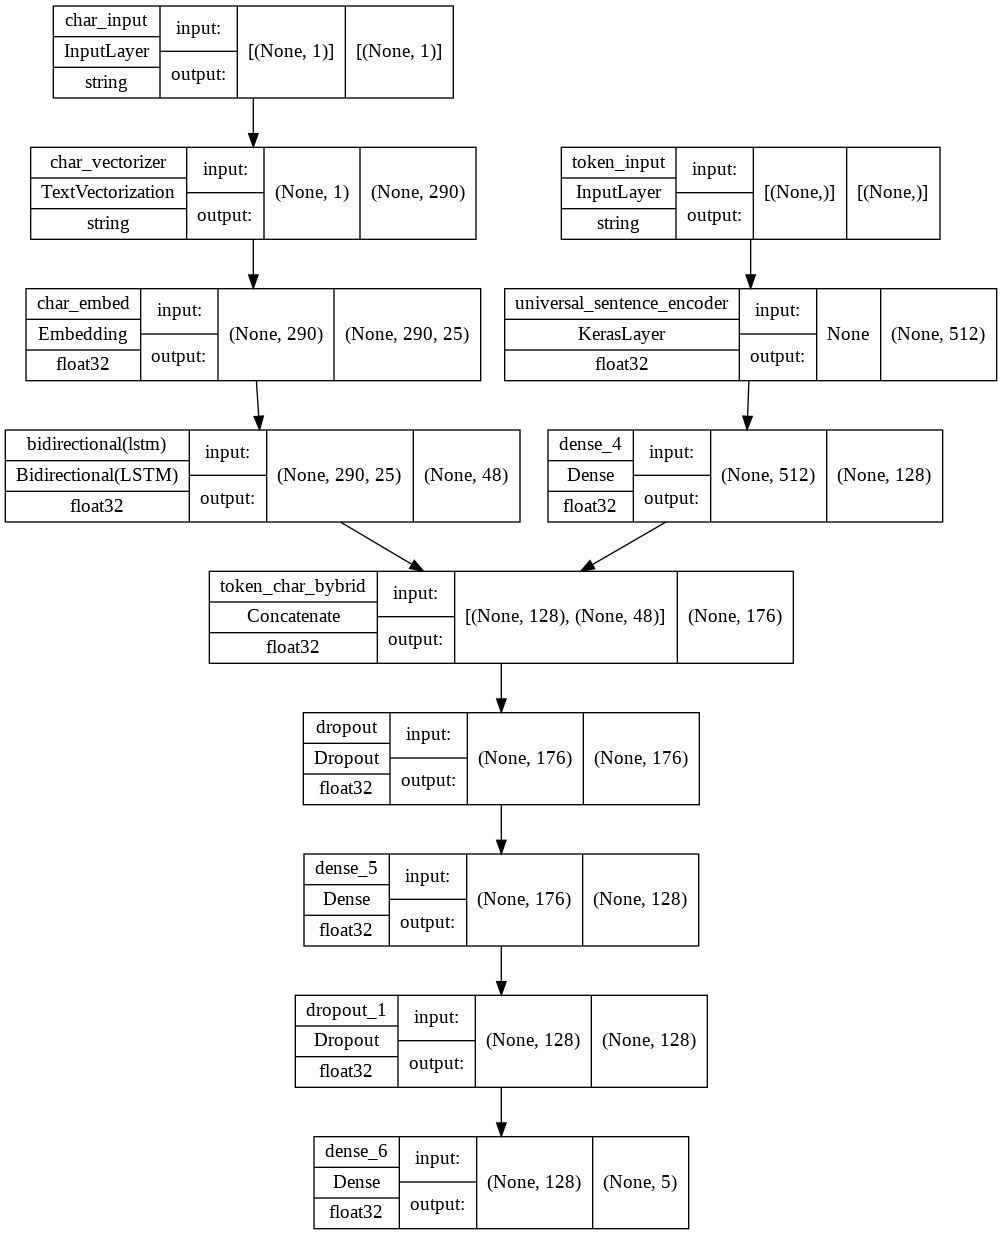

In [ ]:
# Plot hybrid token and character model
import keras
from keras.utils.vis_utils import plot_model
plot_model(model_4,show_shapes=True,show_dtype=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combie data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset


<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combie data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fit the model

In [ ]:
# Fit the model on tokens and chars
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                        epochs=5,
                        validation_data=val_char_token_dataset,
                        validation_steps=int(0.1*len(val_char_token_dataset)))


Epoch 1/5
562/562 [==============================] - 33s 45ms/step - loss: 0.9743 - accuracy: 0.6139 - val_loss: 0.7566 - val_accuracy: 0.7131
Epoch 2/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7878 - accuracy: 0.6989 - val_loss: 0.7009 - val_accuracy: 0.7364
Epoch 3/5
562/562 [==============================] - 21s 38ms/step - loss: 0.7525 - accuracy: 0.7164 - val_loss: 0.6797 - val_accuracy: 0.7394
Epoch 4/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7324 - accuracy: 0.7277 - val_loss: 0.6656 - val_accuracy: 0.7493
Epoch 5/5
562/562 [==============================] - 20s 36ms/step - loss: 0.7258 - accuracy: 0.7305 - val_loss: 0.6377 - val_accuracy: 0.7510


### Evaluate the model

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6364 - accuracy: 0.7573


[0.636441171169281, 0.7573480606079102]

In [ ]:
# Predict the model using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[6.5356129e-01, 1.8221402e-01, 4.1203438e-03, 1.5406476e-01,
        6.0395957e-03],
       [4.7348741e-01, 3.8357404e-01, 5.0422540e-03, 1.3328184e-01,
        4.6145287e-03],
       [3.7941331e-01, 9.6559159e-02, 8.4992431e-02, 4.0369132e-01,
        3.5343751e-02],
       ...,
       [1.5659851e-04, 9.6921722e-04, 2.2882387e-02, 3.8329443e-05,
        9.7595346e-01],
       [1.0421131e-02, 6.1383922e-02, 3.8237405e-01, 4.8747160e-03,
        5.4094625e-01],
       [2.3500566e-01, 5.7805461e-01, 1.3489679e-01, 1.2936568e-02,
        3.9106309e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds[0:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 2, 2, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.73480736131339,
 'f1': 0.7524309060259404,
 'precision': 0.7550154584458142,
 'recall': 0.7573480736131338}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 5
Pretrained token embeddings + Character embeddings + Positional embeddings

1. Create a token-level model
2. Chreate a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1&2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. COmbine the inputs of 1,2,3,4 and outputs of the 7

In [ ]:
df_train.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


🔑 Note: Any engineered features used to train a model need to be avaliable at test time. In our case, line numbers and total lines are available

### Create positional embeddings by using Tensorflow One-Hot-Encoded

### Encoded our `line_number` features

In [ ]:
df_train["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

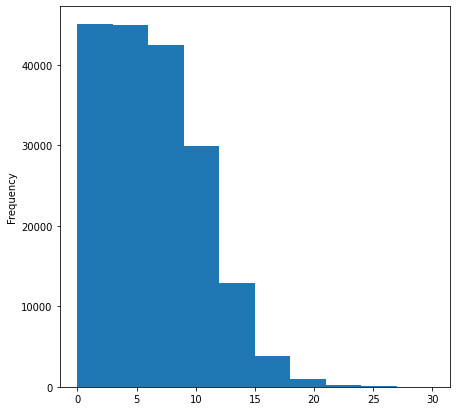

In [ ]:
# Check the distribution of "line_number" column
plt.figure(figsize=(7,7))
df_train["line_number"].plot.hist()

In [ ]:
np.percentile(df_train["line_number"], 95)

13.0

We choose only depth=15 because most of the `line_number` is around 15

In [ ]:
# Use TensorFlow to crate one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(df_train["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(df_val["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(df_test["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
df_train["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

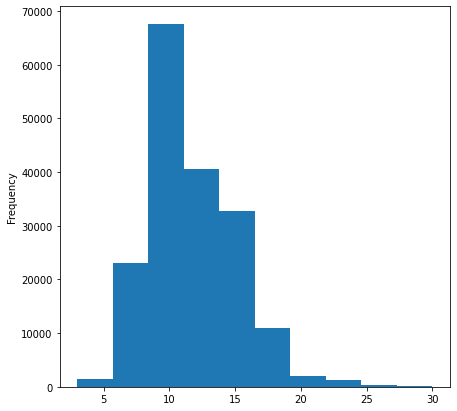

In [ ]:
# Check the distributions of total lines
plt.figure(figsize=(7,7))
df_train["total_lines"].plot.hist()

In [ ]:
# Check the total_lines percentile
np.percentile(df_train["total_lines"],95)

18.0

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(df_train["total_lines"].to_numpy(),depth=18)
val_total_lines_one_hot = tf.one_hot(df_val["total_lines"].to_numpy(),depth=18)
test_total_lines_one_hot = tf.one_hot(df_test["total_lines"].to_numpy(), depth=18)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>, TensorShape([180040, 

### Build the model
5. Combine the outputs of 1&2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. COmbine the inputs of 1,2,3,4 and outputs of the 7

In [ ]:
# Check the line numbers shape for the shape of line numbers model
print(f"Train line numbers shape: {train_line_numbers_one_hot[0].shape}")
print(f"Train line numbers dtype: {train_line_numbers_one_hot.dtype}")

Train line numbers shape: (15,)
Train line numbers dtype: <dtype: 'float32'>


In [ ]:
# Check the total lines shape for the shape of total lines model
print(f"Train total lines shape: {train_total_lines_one_hot[0].shape}")
print(f"Train total lines dtype: {train_total_lines_one_hot.dtype}")

Train total lines shape: (18,)
Train total lines dtype: <dtype: 'float32'>


In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_line_inputs = layers.Input(shape=(18,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                                  outputs = y)

# 5.Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings) # Due to the paper use Dropout so we will create it
z = layers.Dropout(0.5)(z) # paper use Dropout at 0.5

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_line_model.input],
                         outputs=[output_layer])


model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

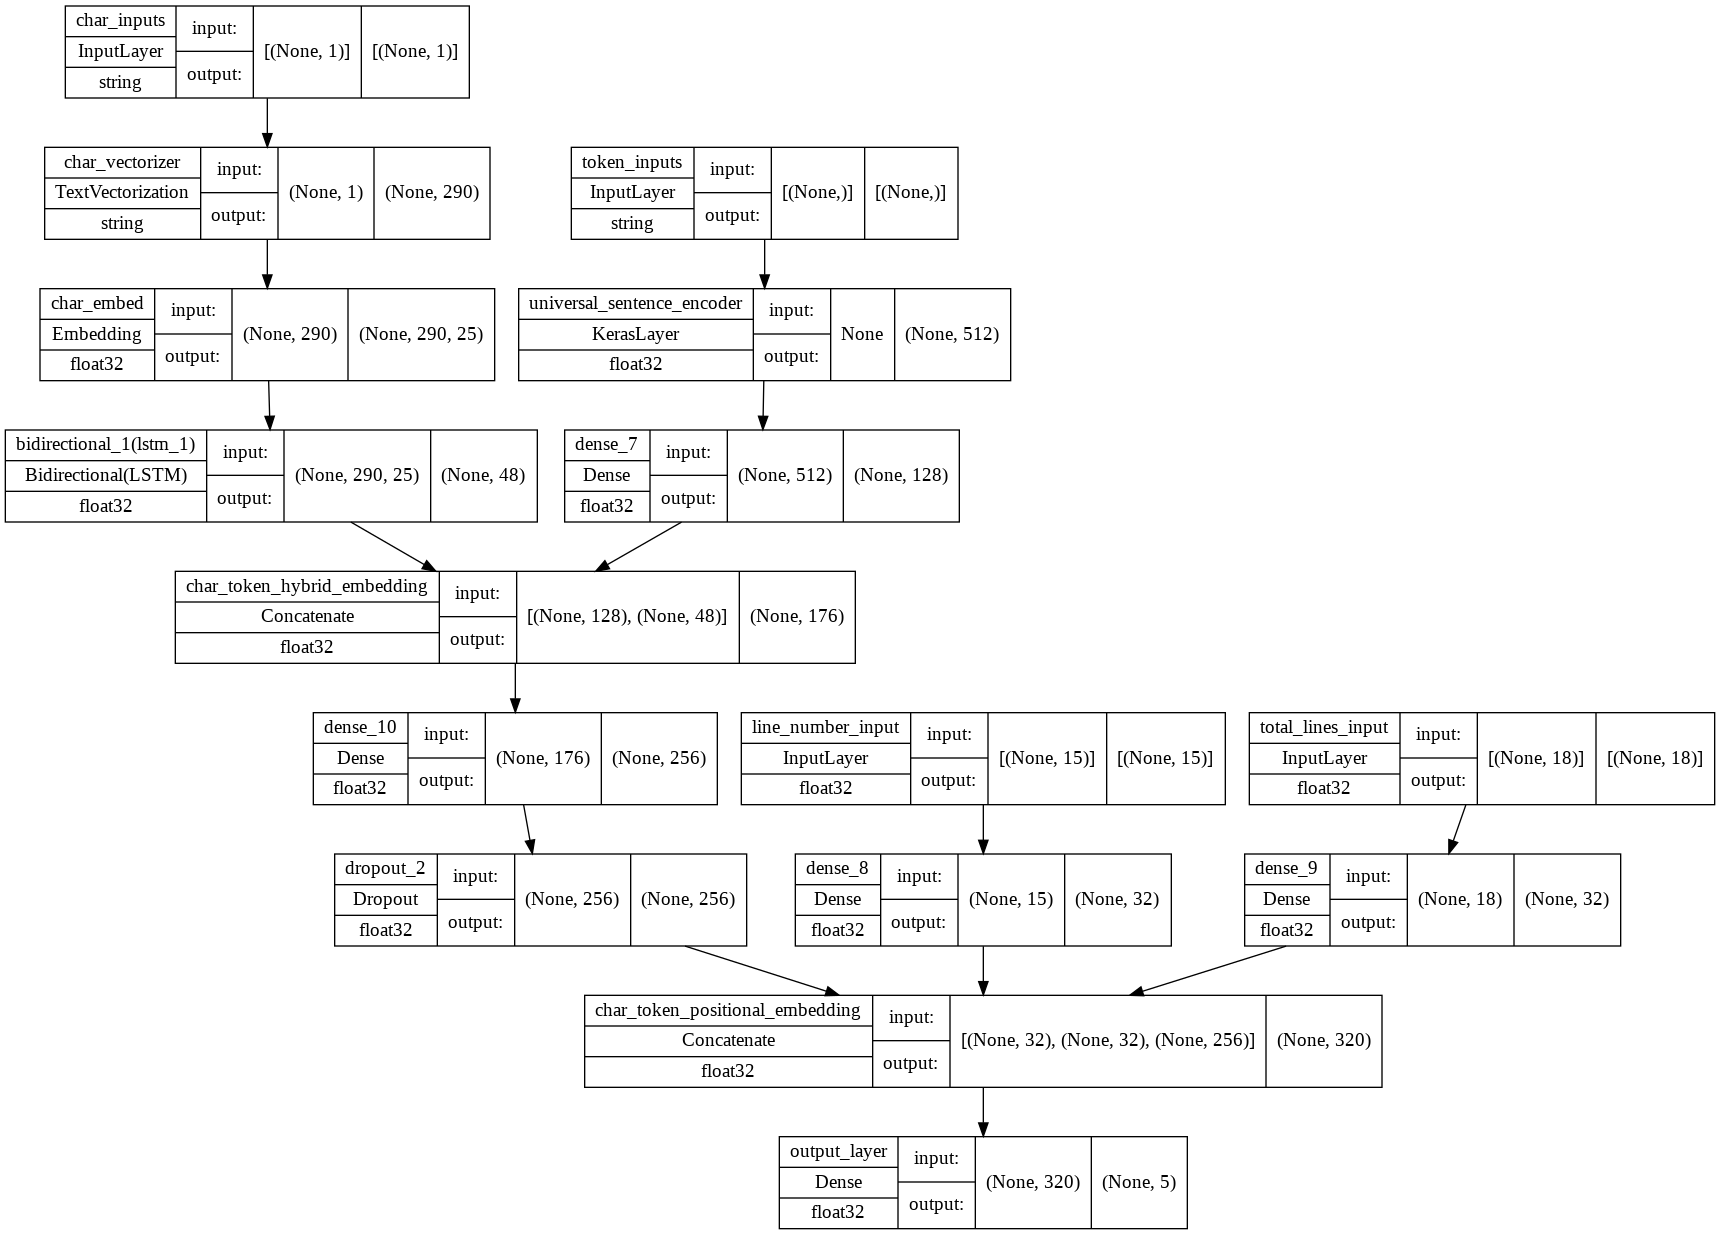

In [ ]:
# Plot the model
plot_model(model_5, show_shapes=True, show_dtype=True)

❓ What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes....

Really Confident Predictions: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classe, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

Resource: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile the model
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'],
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2))

### Create tribrid embedding datasets using tf.data

The order has to be followed by the order of the `model_5` which is
```
inputs=[token_model.input,
     char_model.input,
     line_number_model.input,
     total_line_model.input]
```

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                    train_chars,
                                    train_line_numbers_one_hot,
                                    train_total_lines_one_hot))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                               val_chars,
                               val_line_numbers_one_hot,
                               val_total_lines_one_hot))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fit our tribrid embedding model

In [ ]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                        steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                        epochs=5,
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 32s 43ms/step - loss: 1.0909 - accuracy: 0.7313 - val_loss: 0.9802 - val_accuracy: 0.8045
Epoch 2/5
562/562 [==============================] - 22s 39ms/step - loss: 0.9606 - accuracy: 0.8204 - val_loss: 0.9436 - val_accuracy: 0.8321
Epoch 3/5
562/562 [==============================] - 21s 38ms/step - loss: 0.9411 - accuracy: 0.8300 - val_loss: 0.9337 - val_accuracy: 0.8388
Epoch 4/5
562/562 [==============================] - 21s 37ms/step - loss: 0.9368 - accuracy: 0.8386 - val_loss: 0.9281 - val_accuracy: 0.8351
Epoch 5/5
562/562 [==============================] - 21s 38ms/step - loss: 0.9293 - accuracy: 0.8421 - val_loss: 0.9201 - val_accuracy: 0.8474


### Evaluate the model

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.9160 - accuracy: 0.8483


[0.9159770011901855, 0.8483052849769592]

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 20s 19ms/step


array([[0.6266964 , 0.08973648, 0.01659808, 0.24435809, 0.02261091],
       [0.6285051 , 0.07875916, 0.09541061, 0.18198451, 0.01534064],
       [0.39452666, 0.11534446, 0.14762232, 0.28695062, 0.05555599],
       ...,
       [0.03356262, 0.08382943, 0.0491436 , 0.03265953, 0.8008048 ],
       [0.02274638, 0.2574905 , 0.11222942, 0.02143745, 0.5860962 ],
       [0.09584285, 0.702431  , 0.09984364, 0.02878629, 0.07309621]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.83053091486826,
 'f1': 0.8441201056136544,
 'precision': 0.8522998375482093,
 'recall': 0.8483053091486826}

# Compare all the model results

In [ ]:
import pandas as pd
all_model_results = pd.DataFrame({"model_0_Naive_Bayes": model_0_results, 
              "model_1_Conv1D": model_1_results,
              "model_2_Pretrained": model_2_results,
              "model_3_Conv1D_Chars_Embedding": model_3_results,
              "model_4_TokenChars_Embedding": model_4_results,
              "model_5_TokenCharsPos_Embedding": model_5_results})

all_model_results = all_model_results.transpose()

# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_Naive_Bayes,0.721832,0.718647,0.721832,0.698925
model_1_Conv1D,0.818549,0.820228,0.818549,0.815705
model_2_Pretrained,0.725837,0.721694,0.725837,0.720278
model_3_Conv1D_Chars_Embedding,0.716768,0.718745,0.716768,0.710960
model_4_TokenChars_Embedding,0.757348,0.755015,0.757348,0.752431
model_5_TokenCharsPos_Embedding,0.848305,0.852300,0.848305,0.844120


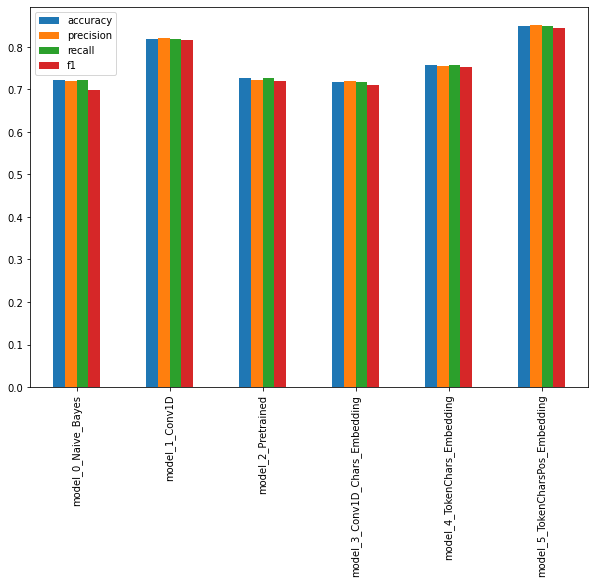

In [ ]:
# {lot and compare all model results}
all_model_results.plot(kind="bar",figsize=(10,7))

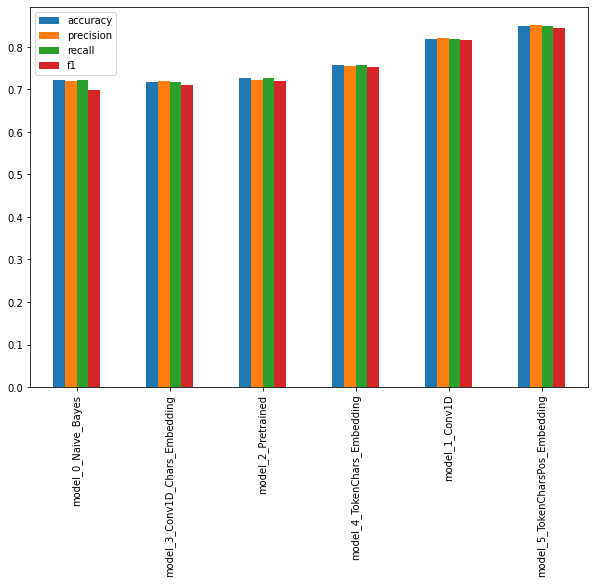

In [ ]:
all_model_results.sort_values("f1",ascending=True).plot(kind="bar",figsize=(10,7))

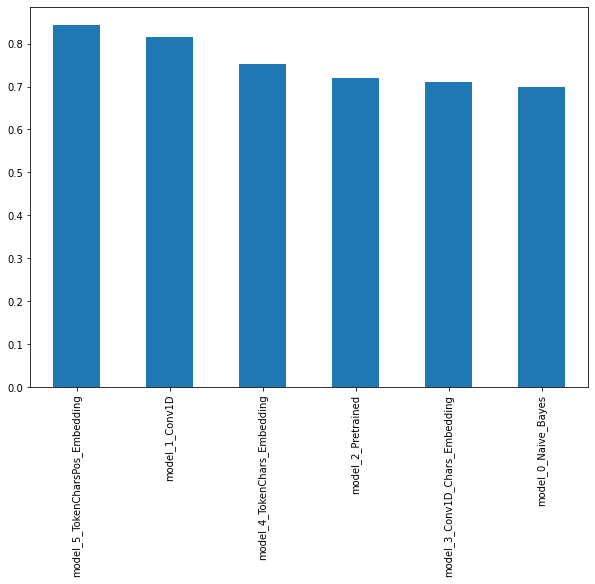

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

# Save and load model

In [ ]:
# Save the best performing model to SaveModel format
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on the validation dataset
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 21s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 2, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 84.83053091486826,
 'f1': 0.8441201056136544,
 'precision': 0.8522998375482093,
 'recall': 0.8483053091486826}

In [ ]:
model_5_results

{'accuracy': 84.83053091486826,
 'f1': 0.8441201056136544,
 'precision': 0.8522998375482093,
 'recall': 0.8483053091486826}

In [ ]:
loaded_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [ ]:
df_test

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


# Evaluate model on test dataset

In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                               test_chars,
                                                               test_line_numbers_one_hot,
                                                               test_total_lines_one_hot))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the dataset
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset, verbose=1)
test_pred_probs[:10]

942/942 [==============================] - 18s 19ms/step


array([[0.28082445, 0.07768787, 0.17939165, 0.35449916, 0.10759687],
       [0.23817736, 0.04416263, 0.47945818, 0.19042432, 0.04777753],
       [0.05952172, 0.02105312, 0.8322895 , 0.06003486, 0.02710077],
       [0.02094428, 0.02076654, 0.8514652 , 0.02628629, 0.08053766],
       [0.04454224, 0.06257376, 0.2065333 , 0.04713367, 0.6392171 ],
       [0.02707141, 0.02124152, 0.06440474, 0.0290527 , 0.8582297 ],
       [0.01386089, 0.0861496 , 0.4769185 , 0.02375407, 0.39931694],
       [0.07930366, 0.54094666, 0.15715699, 0.03720111, 0.18539159],
       [0.0259505 , 0.5329156 , 0.05085504, 0.02359509, 0.36668378],
       [0.6230107 , 0.03294683, 0.05953629, 0.26056775, 0.02393844]],
      dtype=float32)

In [ ]:
# Put into argmax and see the first 10 results
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[0:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 2, 1, 1, 0])>

In [ ]:
# Calculate the results
calculate_results(test_labels_encoded, test_preds)

{'accuracy': 84.4632487141198,
 'f1': 0.8404597309561059,
 'precision': 0.8480114304575052,
 'recall': 0.844632487141198}

# Find the most wrong

## Convert all of our inter-base to string-based

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 11.3 s, sys: 904 ms, total: 12.2 s
Wall time: 10.4 s


In [ ]:
print(f"Shape of 'test_pred_classes' {len(test_pred_classes)}")
test_pred_classes[0:10]

Shape of 'test_pred_classes' 30135


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

## Create prediction test dataframe

In [ ]:
df_test["prediction"] = test_pred_classes # Create column with test prediction class names
df_test["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # Get the maximum prediction probability https://www.tensorflow.org/api_docs/python/tf/math/reduce_max
df_test["correction"] = df_test["prediction"] == df_test["target"]

### Inspect the DataFrame table

In [ ]:
df_test.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correction
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.354499,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.479458,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.832290,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.851465,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.639217,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.858230,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.476918,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.540947,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.532916,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.623011,True


In [ ]:
# Find how many % that our model predict is correct
df_test["correction"].value_counts()

True     25453
False     4682
Name: correction, dtype: int64

In [ ]:
correct_percent = round(df_test["correction"].value_counts()[True] / df_test.shape[0],3)
print(f" Precentage that the prediction is correct: {correct_percent}")

 Precentage that the prediction is correct: 0.845


## Find the most wrong

We might want to see what's the most wrong by creating the new table and see what's target is that contain the highest "pred_prob" and the prediction is still wrong

### Create the top 100 most wrong

In [ ]:
# Find 100 most wrong
top_100_wrong = df_test[df_test["correction"] == False].sort_values("pred_prob", ascending = False)[0:100]
top_100_wrong.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correction
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.967970,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.955290,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.947987,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.945957,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.945128,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.940472,False
20040,CONCLUSIONS,chictr.org .,11,12,BACKGROUND,0.927668,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.925869,False
16580,OBJECTIVE,"second , we collected patient-reported outcome...",4,27,METHODS,0.921852,False
21382,OBJECTIVE,"design , settings , participants , and interve...",3,13,METHODS,0.920205,False


In [ ]:
for row in top_100_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9679703116416931, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9552901387214661, Line number: 4, Total lines: 15

Text:
patients were randomized in a bayesian response-adaptive design to receive intravenous decitabine @ mg/m ( @ ) daily for @ days or decitabine plus oral valproic acid @ mg/kg daily for @ days .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9479867815971375, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.9459565281867981, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.945127546787262, Line number: 4, Total lines: 12

Text:
patients were randomly assigned to receive either moxonidine ( @-@ @ mg daily ) or placebo , along with standard antihypertensive treatment .

-----

Target:

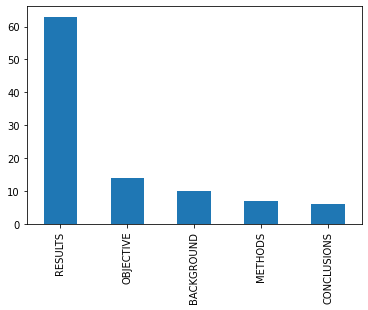

In [ ]:
top_100_wrong["target"].value_counts().plot(kind="bar")